In [1]:
import fastai
from fastai import *          # Quick access to most common functionality
from fastai.vision import *   # Quick access to computer vision functionality
from fastai.layers import Lambda
from fastai.callbacks import SaveModelCallback
import pytorch_ssim as ssim
from superres import *

In [2]:
path = Path('/DATA/WAMRI/salk/uri/Image_restoration_data/')
train_lr = path/'train_LR'
train_hr = path/'train_HR'
test_lr = path/'test_LR'
test_hr = path/'test_HR'

In [3]:
def pull_id(fn):
    return fn.split('#')[-1].split('.')[0]

def match_hr_fn(x):
    return hr_names_by_id[pull_id(x.name)]

lr_names_full = list(train_lr.glob('*.tif'))
lr_names_full.sort()
hr_names_by_id = {pull_id(hrfn.name):hrfn for hrfn in train_hr.glob('*.tif')}
test_label = list(hr_names_by_id.values())[0]

In [4]:
src = (GrayImageItemList
       .from_folder(train_lr, '*.tif', label_class=GrayImageItemList)
       .split_by_valid_func(lambda x: x.stem[-3] == '0')
       .label_from_func(match_hr_fn))

In [6]:
scale=4
n_resblocks=16
n_feats=128
res_scale= 1.
model = WDSR(scale, n_resblocks, n_feats, res_scale, n_colors_in=1)
model = nn.DataParallel(model) #.eval().cuda()

In [7]:
sz_lr = 72
scale,bs = 4,24
sz_hr = sz_lr*scale
loss = combo_edge_mse
#loss=feat_proj_loss
#loss=combo2

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


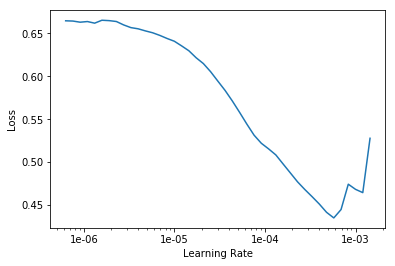

In [9]:
learn = build_learner(model, bs, sz_lr, sz_hr, src, loss=loss)
learn.lr_find()
learn.recorder.plot()

save: wdsr_1.0


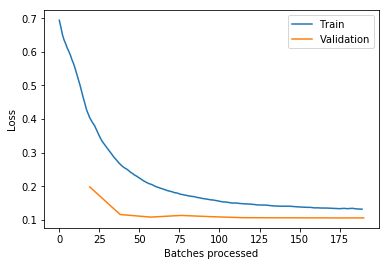

In [10]:
epochs, lr = 10, 2e-4
learn = batch_learn(model, bs, sz_lr, sz_hr, lr, epochs, src, save='wdsr_1.0', loss=loss)

In [11]:
torch.save(learn.model.module, "wdsr_model_1")

load: wdsr_1.0_best


save: wdsr_1.1


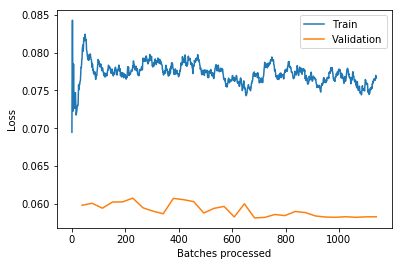

In [12]:
sz_lr = 128
scale,bs = 4,12
sz_hr = sz_lr*scale
epochs, lr = 30, 1e-4
learn = batch_learn(model, bs, sz_lr, sz_hr, lr, epochs, src, load='wdsr_1.0_best', save='wdsr_1.1', loss=loss)

In [13]:
learn = learn.load('wdsr_1.1')
torch.save(learn.model.module,'wdsr_model_1.1')

load: wdsr_1.1


save: wdsr_1.2


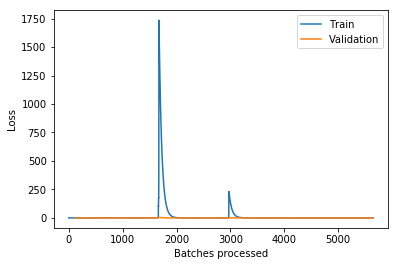

In [14]:
sz_lr = 256
scale,bs = 4,4
sz_hr = sz_lr*scale
epochs, lr = 50, 1e-3
learn = batch_learn(model, bs, sz_lr, sz_hr, lr, epochs, src, load='wdsr_1.1', save='wdsr_1.2', loss=loss)

In [15]:
learn = learn.load('wdsr_1.2')
torch.save(learn.model.module,'wdsr_model_1.2')

load: wdsr_1.2


save: wdsr_1.3


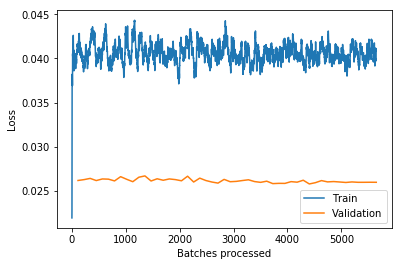

In [16]:
sz_lr = 256
scale,bs = 4,4
sz_hr = sz_lr*scale
epochs, lr = 50, 1e-4
learn = batch_learn(model, bs, sz_lr, sz_hr, lr, epochs, src, load='wdsr_1.2', save='wdsr_1.3', loss=loss)

In [17]:
learn = learn.load('wdsr_1.3')
torch.save(learn.model.module,'wdsr_model_1.3')

In [18]:
learn = learn.load('wdsr_1.3_best')
torch.save(learn.model.module,'wdsr_model_1.3_best')

In [19]:
learn = learn.load('wdsr_1.3_best')

In [20]:
sz_lr = 506
scale,bs = 4,1
sz_hr = sz_lr*scale
data = get_data(src, bs, sz_lr, sz_hr)
learn = Learner(data, model, loss_func=F.mse_loss)
preds, ys = learn.get_preds(DatasetType.Valid)
preds = torch.clamp(preds, 0.,1.)

In [21]:
idx = 9
ys[idx].std(), preds[idx].std()

(tensor(0.1262), tensor(0.0953))

In [22]:
preds[idx].min(),preds[idx].max()

(tensor(0.), tensor(0.7735))

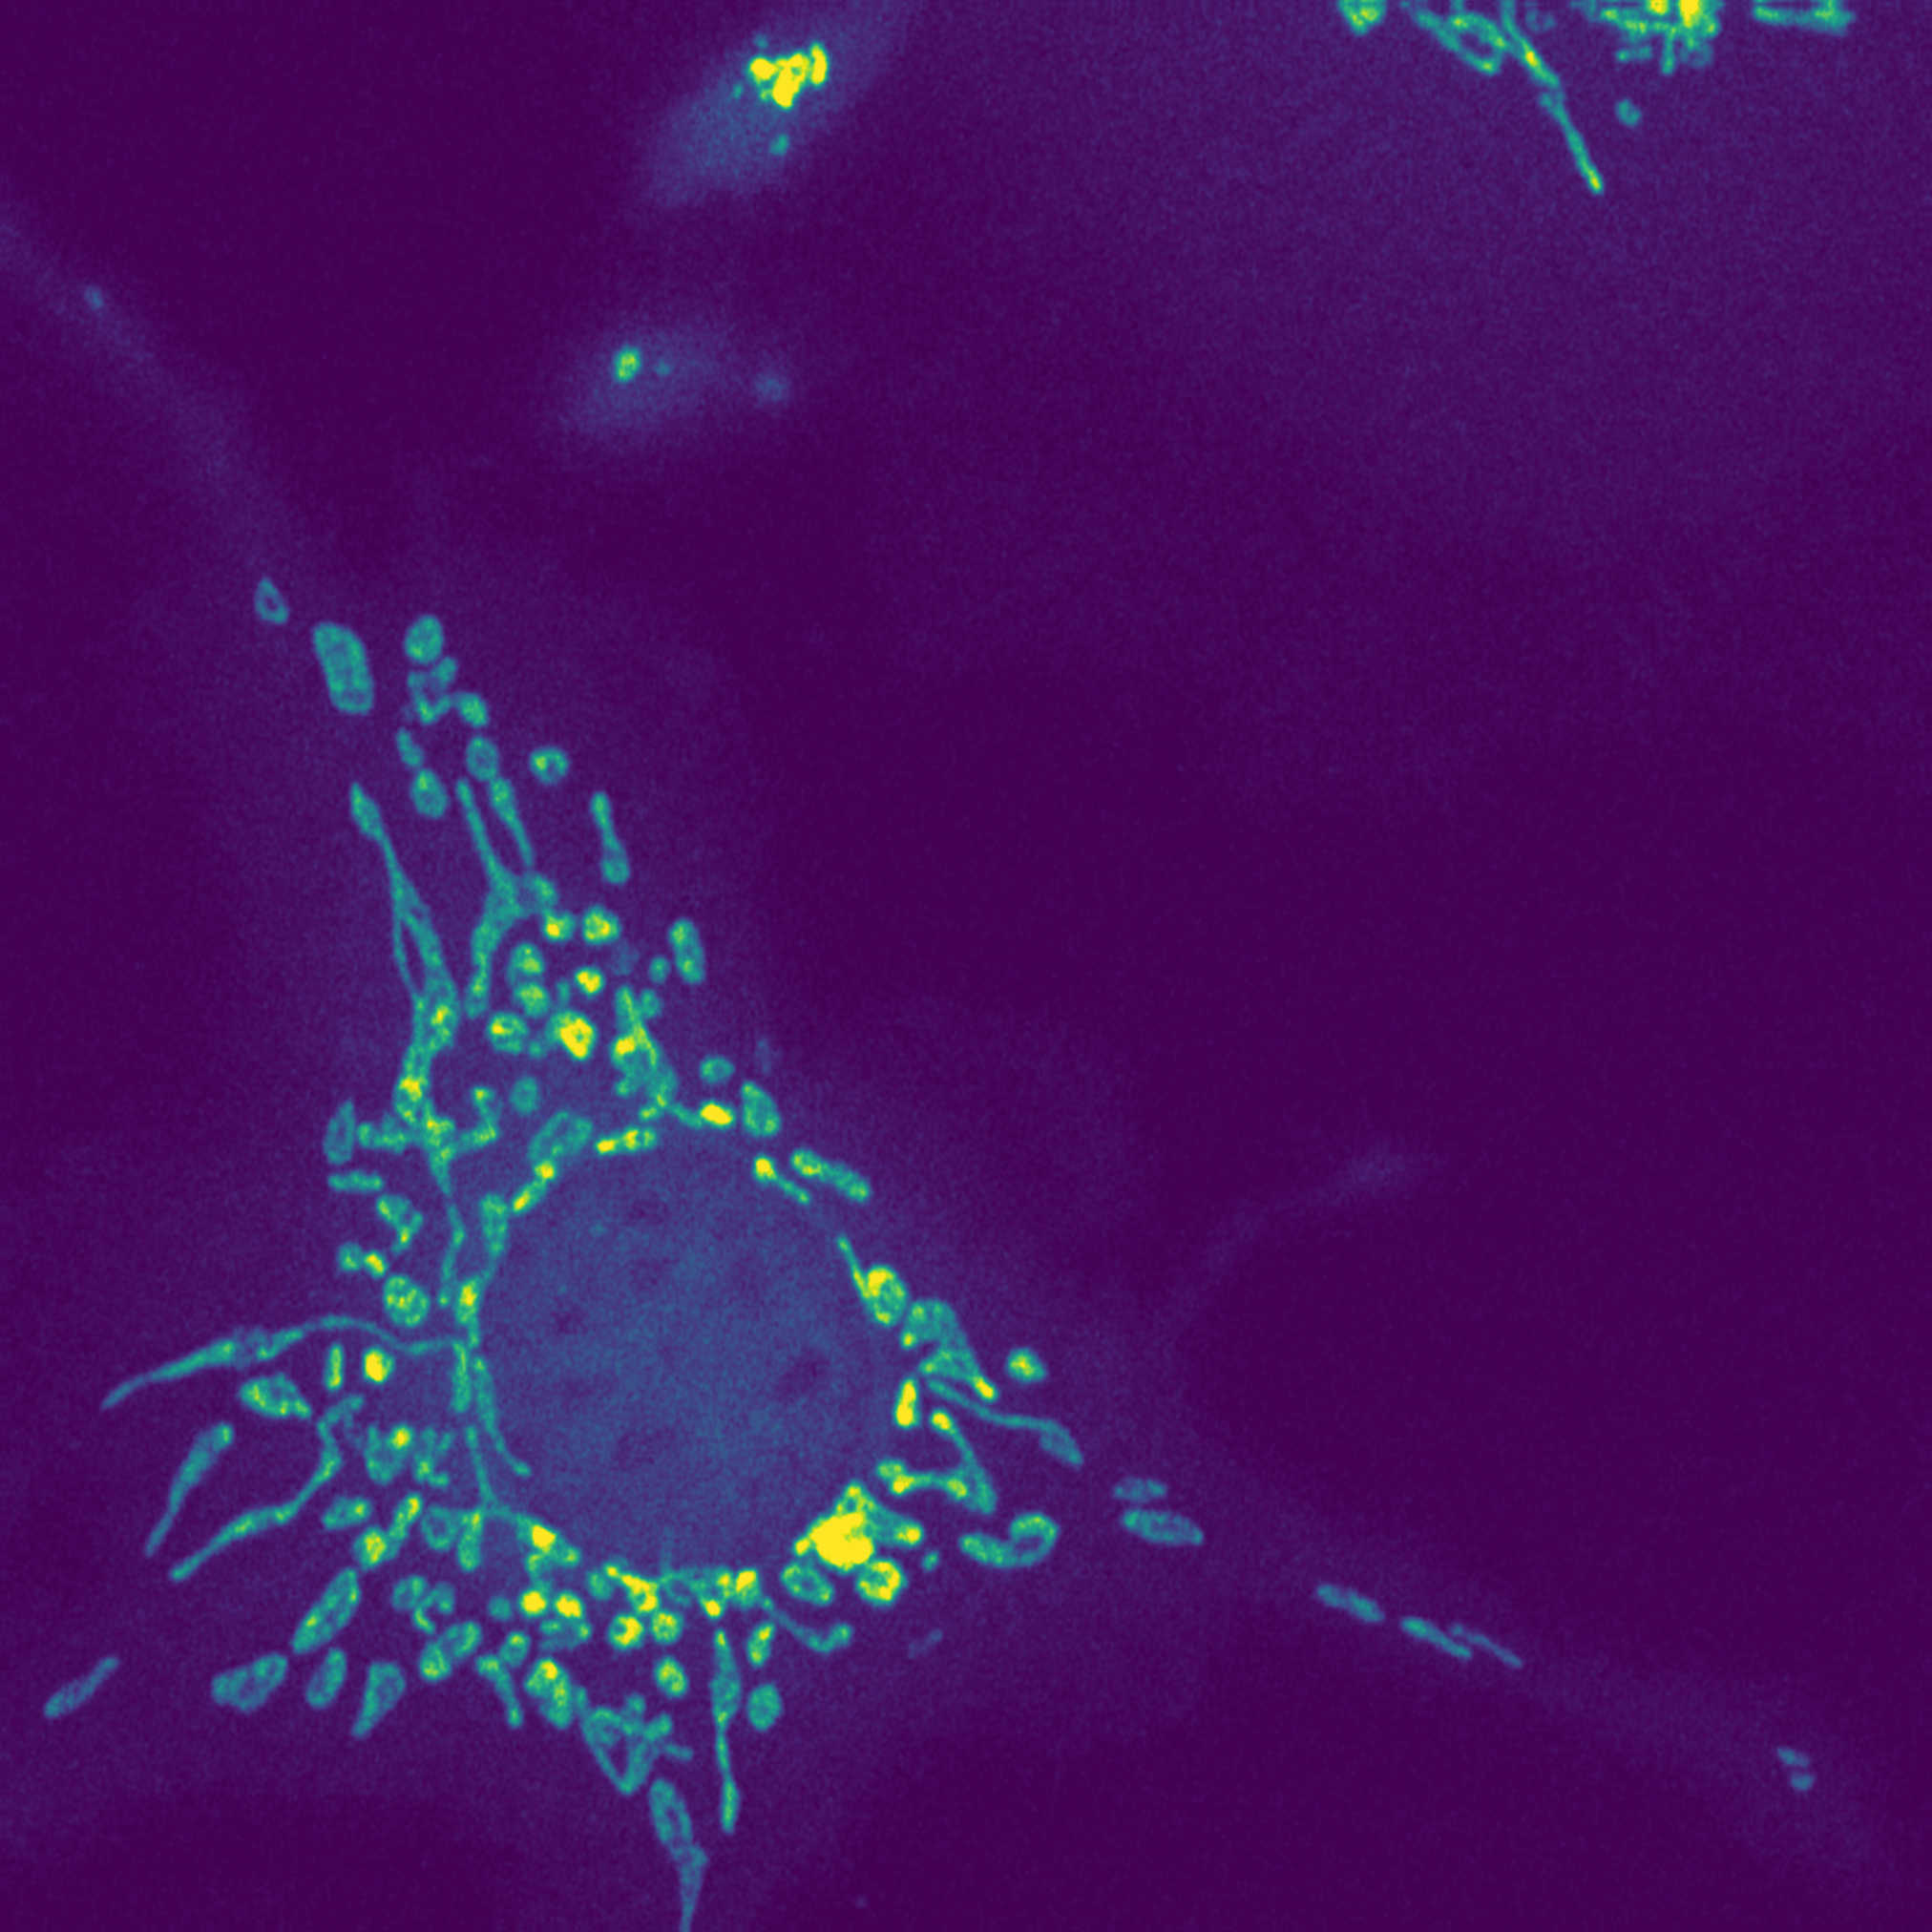

In [23]:
hr = Image(ys[idx])
hr

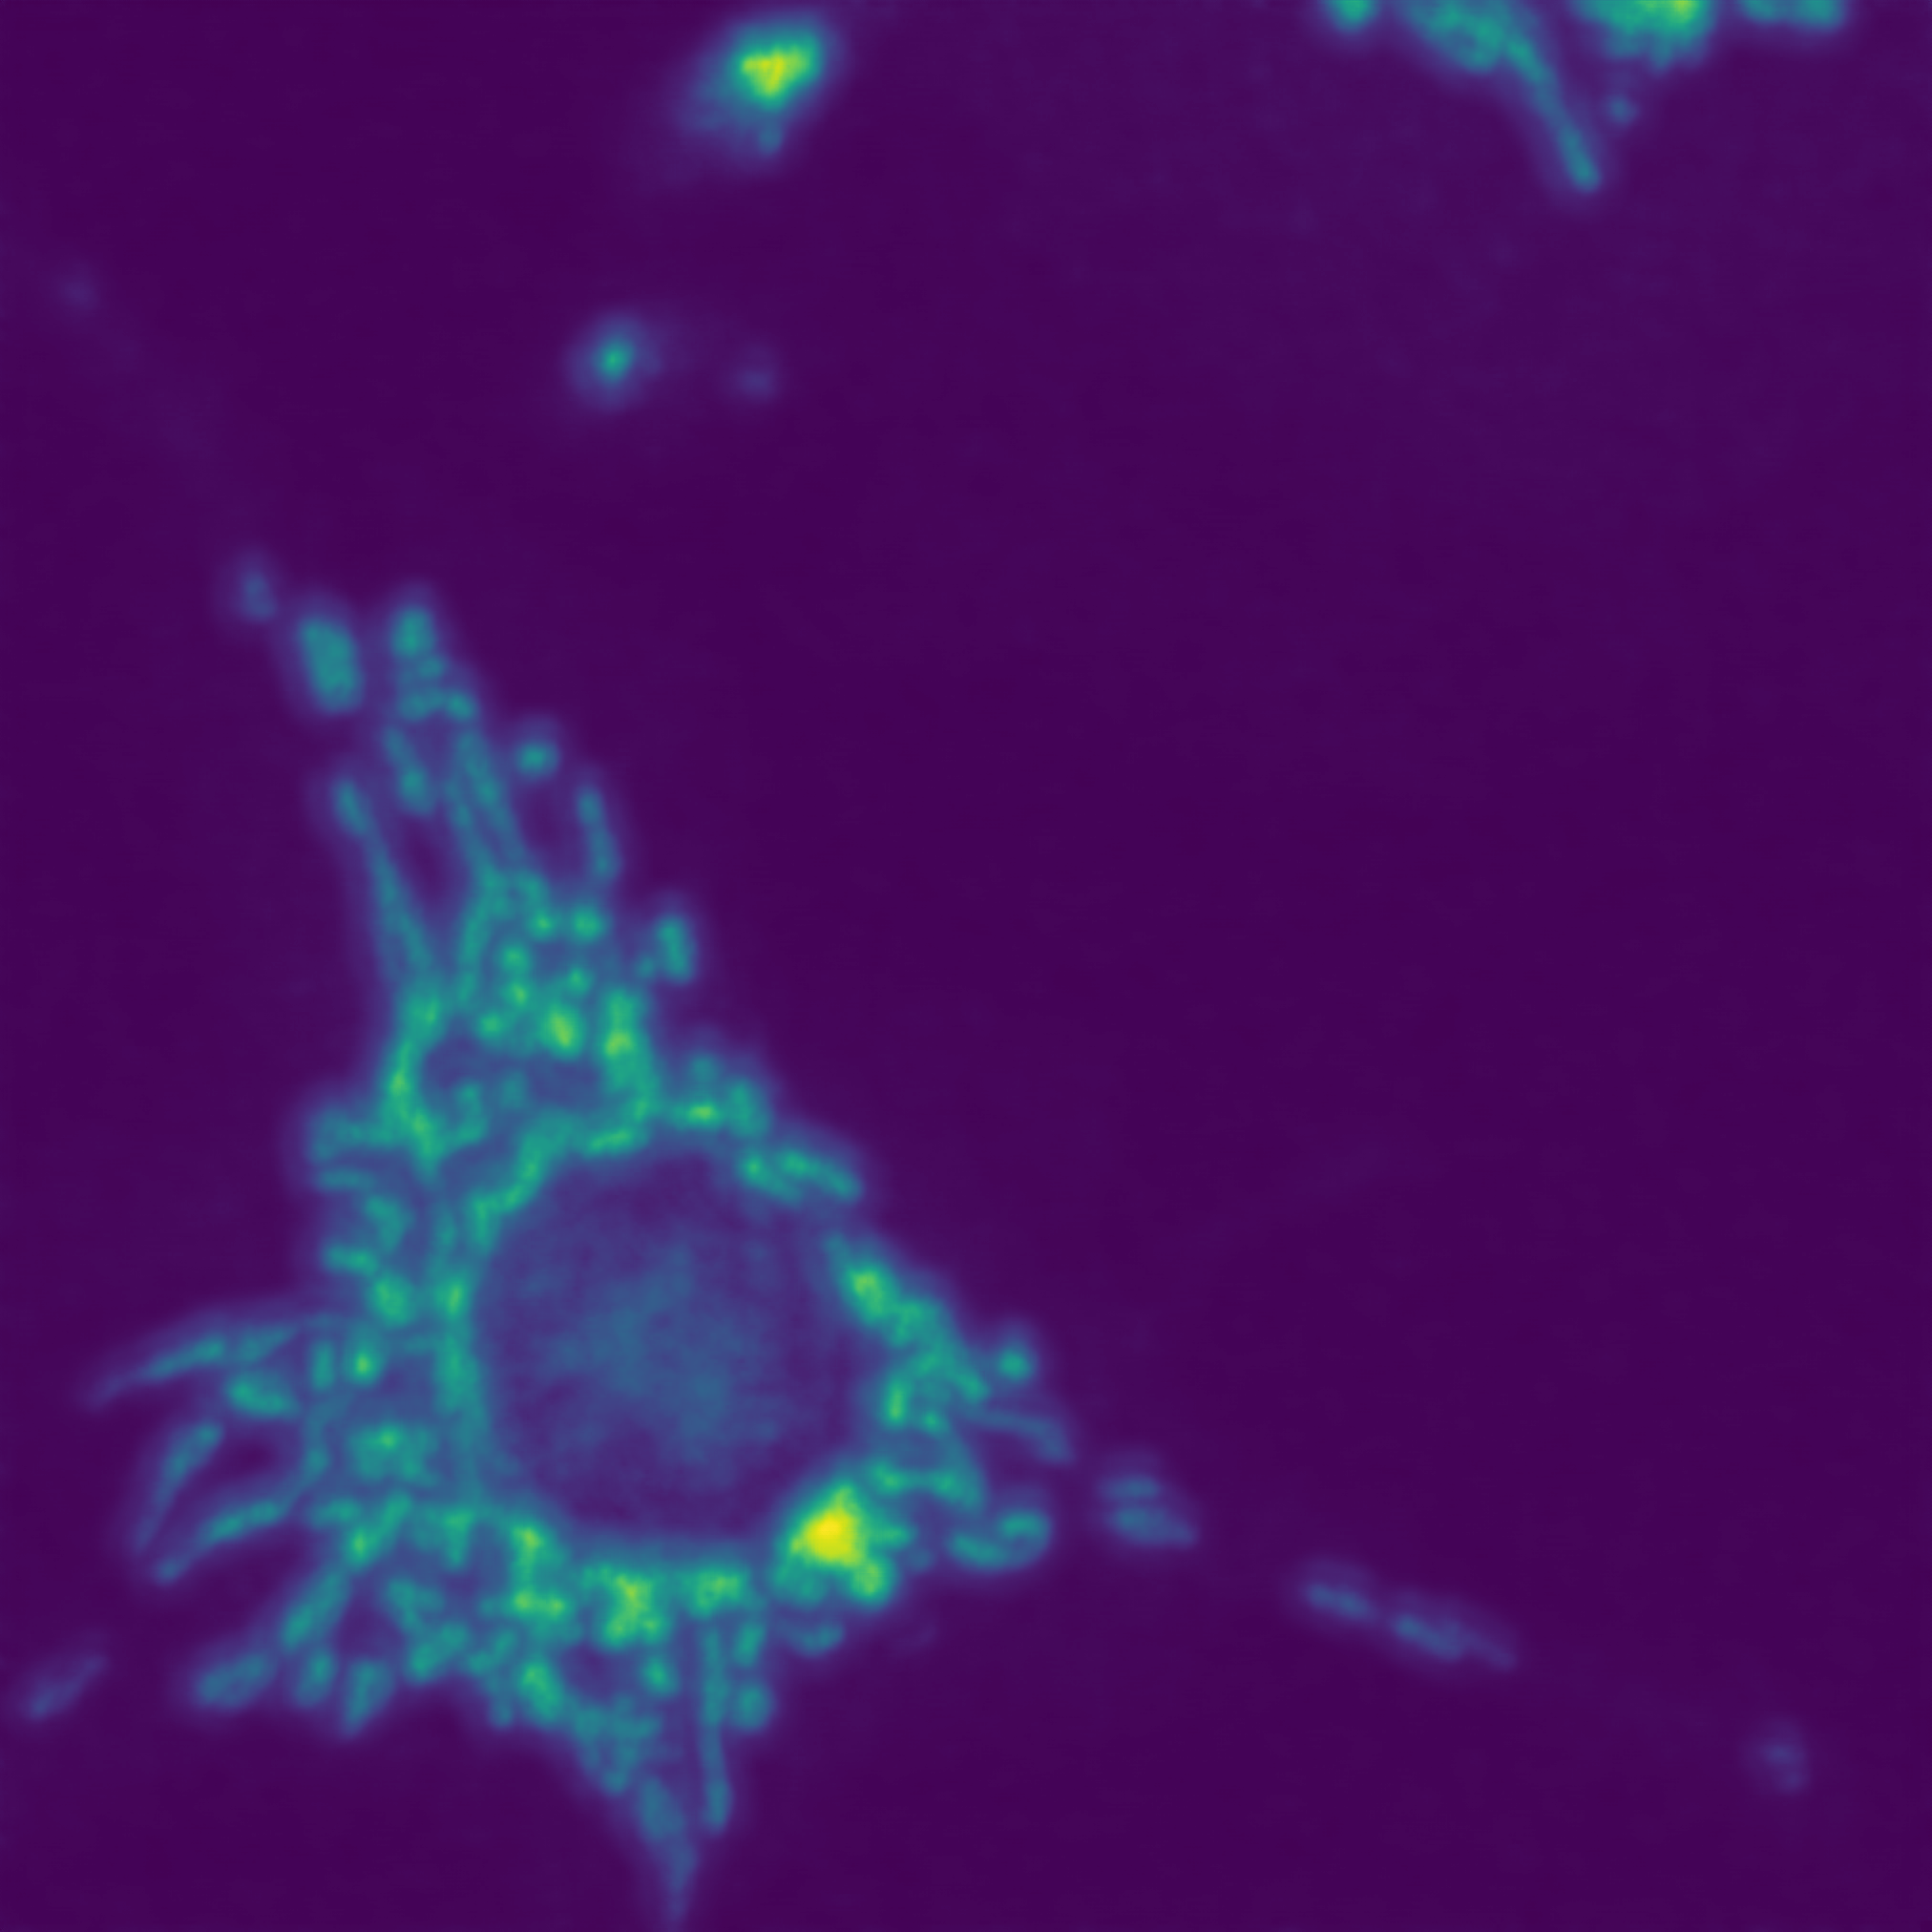

In [24]:
sr = Image(preds[idx])
sr

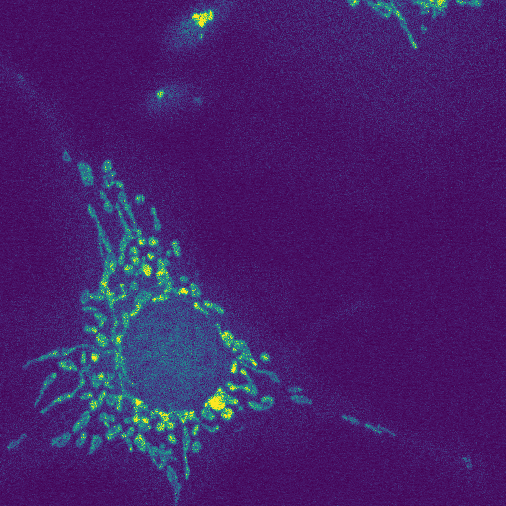

In [25]:
lr = learn.data.valid_ds[idx][0]
lr

In [26]:
ssim.ssim(sr.data[None],hr.data[None]), psnr(sr.data[None],hr.data[None]), F.mse_loss(sr.data[None],hr.data[None])

(tensor(0.7725), tensor(22.8943), tensor(0.0051))

In [27]:
learn.save('wdsr')

AttributeError: 'Learner' object has no attribute 'opt'

In [29]:
learn = learn.load('wdsr')

In [30]:
trn_tfm, val_tfm = get_transforms()
test_bs = 2
test_sz = 512 
test_out_sz = 4*test_sz
test_data = get_data(src, test_bs, test_sz, test_out_sz, test_folder=path/'newimg')
test_learn = Learner(test_data, model, loss_func=F.mse_loss).load('wdsr')

NameError: name 'test_label' is not defined

In [ ]:
test_preds, ys = test_learn.get_preds(DatasetType.Test)
test_preds = torch.clamp(test_preds, 0.,1.)

In [ ]:
sr_imgs = []
for idx in range(test_preds.shape[0]):
    img = Image(test_preds[idx])
    sr_imgs.append(img)

In [ ]:
sr_imgs[1]

In [ ]:
sr_imgs[0]

In [ ]:
test_learn.save('wdsr_keep_edge3')

In [ ]:
test_learn.save('wdsr_keep_edge3')